In [2]:
# Celula 1: Configurare Doppler și Încărcare Model Existent
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo

DOPPLER_IMG_DIR = r"C:\Users\Alex\Desktop\Proiect Lymphonod\Doppler\img"
DOPPLER_ANN_DIR = r"C:\Users\Alex\Desktop\Proiect Lymphonod\Doppler\ann"

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.50 
cfg.MODEL.DEVICE = "cpu"
cfg.MODEL.ROI_MASK_HEAD.POOLER_RESOLUTION = 28 

predictor = DefaultPredictor(cfg)
print("Modelul a fost încărcat. Pregătit pentru analiza Doppler.")

Modelul a fost încărcat. Pregătit pentru analiza Doppler.


In [3]:
# Celula 2: Algoritmi Matematici Doppler (Conform PDF JCM-14-01828)

def crop_spectral_doppler(image):
    """
    Funcție de pre-procesare pentru imaginile late (Split-Screen).
    Dacă lățimea e mult mai mare decât înălțimea, tăiem partea dreaptă (graficul).
    """
    h, w = image.shape[:2]
    if w > 1.3 * h:
        new_w = int(w * 0.55)
        return image[:, :new_w]
    return image

def smooth_mask(mask_raw):
    mask_blurred = cv2.GaussianBlur(mask_raw, (19, 19), 0)
    _, mask_smooth = cv2.threshold(mask_blurred, 127, 255, cv2.THRESH_BINARY)
    return mask_smooth

def get_vascular_metrics(image, mask):
    """
    Implementare strictă a Algoritmilor 2 și 3 din PDF.
    """
    masked_img = cv2.bitwise_and(image, image, mask=mask)
    hsv = cv2.cvtColor(masked_img, cv2.COLOR_BGR2HSV)
    
    lower_color = np.array([0, 40, 40])
    upper_color = np.array([180, 255, 255])
    
    vascular_mask = cv2.inRange(hsv, lower_color, upper_color)
    vascular_mask = cv2.bitwise_and(vascular_mask, vascular_mask, mask=mask)
    
    count_total = cv2.countNonZero(mask)
    count_color = cv2.countNonZero(vascular_mask)
    
    if count_total == 0: return 0.0, 0.0, vascular_mask
    
    vasc_percent = (count_color / count_total) * 100
    
    M = cv2.moments(mask)
    if M["m00"] == 0: return vasc_percent, 0.0, vascular_mask
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    
    y_col, x_col = np.where(vascular_mask > 0)
    if len(x_col) > 0:
        dists_color = np.sqrt((x_col - cX)**2 + (y_col - cY)**2)
        avg_dist_color = np.mean(dists_color)
    else:
        avg_dist_color = 0
        
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        pts = contours[0].reshape(-1, 2)
        dists_contour = np.sqrt((pts[:, 0] - cX)**2 + (pts[:, 1] - cY)**2)
        avg_dist_contour = np.mean(dists_contour)
    else:
        avg_dist_contour = 1.0
        
    if avg_dist_contour > 0:
        position_ratio = avg_dist_color / avg_dist_contour
    else:
        position_ratio = 0.0
        
    return vasc_percent, position_ratio, vascular_mask

Analizez (Full Image): ADP_LC_20120719115629.bmp

=== RAPORT DOPPLER ===
* Vasc. Ratio: 0.8%
* Vasc. Pos:   0.94 [Periferic (Suspect)]
* Shape Ratio: 0.66
* AI Conf:     97%
* RESULT:      SUSPECT (Malign)


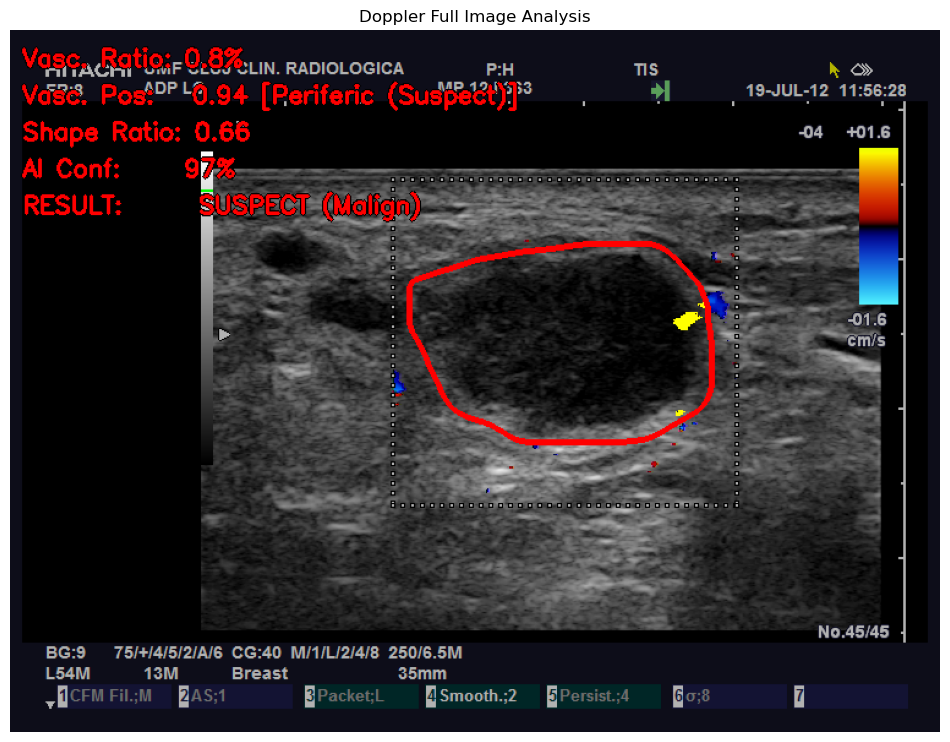

In [18]:
# Celula 3 (Doppler Final): Analiză pe Întreaga Imagine (Fără Crop)
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from detectron2.engine import DefaultPredictor 

def get_files(d):
    return [os.path.join(d, f) for f in os.listdir(d) if f.lower().endswith(('.jpg','.png','.bmp'))]

def preprocess_full_image(image):
    """
    Pregătește imaginea pentru AI:
    1. NU mai tăiem nimic (analizăm tot).
    2. Extragem Canalul V (Luminanță) din HSV pentru a ignora culorile roșu/albastru.
    3. Aplicăm Blur pentru a șterge liniile punctate ale cutiei Doppler.
    """
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
   
    v_blurred = cv2.medianBlur(v, 5)
    
    img_ai = cv2.cvtColor(v_blurred, cv2.COLOR_GRAY2BGR)
    
    return img_ai

def expand_mask(mask, percent=0.15):
    """
    Mărește masca cu 15% pentru a prinde vasele de la margine,
    deoarece AI-ul tinde să sub-estimeze conturul sub culori.
    """
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours: return mask
    
    rect = cv2.boundingRect(contours[0])
    w_obj = rect[2]
    
    kernel_size = int(w_obj * percent)
    if kernel_size % 2 == 0: kernel_size += 1 
    if kernel_size < 3: kernel_size = 3
    
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    mask_expanded = cv2.dilate(mask, kernel, iterations=1)
    return mask_expanded

files = get_files(DOPPLER_IMG_DIR)

if not files:
    print("Nu sunt imagini în folderul img_doppler!")
else:
    img_path = random.choice(files)
    im_orig = cv2.imread(img_path)
    
    im_ai = preprocess_full_image(im_orig)
    
    print(f"Analizez (Full Image): {os.path.basename(img_path)}")
    
    outputs = predictor(im_ai)
    instances = outputs["instances"].to("cpu")
    
    img_display = im_orig.copy()
    
    if len(instances) > 0:
        best = instances[0]
        score_ai = best.scores.numpy()[0]
        
        mask_raw = best.pred_masks[0].numpy().astype('uint8') * 255
        mask_smooth = smooth_mask(mask_raw)
        mask_final = expand_mask(mask_smooth, percent=0.12) 
        
        vasc_pct, vasc_pos, vasc_mask = get_vascular_metrics(im_orig, mask_final)
        
        contours, _ = cv2.findContours(mask_final, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnt = contours[0]
        
        if len(cnt) >= 5:
            ellipse = cv2.fitEllipse(cnt)
            (center, axes, angle) = ellipse
            MA, ma = axes
            shape_ratio = min(MA, ma) / max(MA, ma) if max(MA, ma) > 0 else 0
            
            score_malign = 0
            
            if shape_ratio > 0.6: score_malign += 1
            
            if vasc_pct > 15.0: score_malign += 1.5
            
            if vasc_pos > 0.5:
                score_malign += 1
                pos_label = "Periferic (Suspect)"
            else:
                pos_label = "Central (Normal)"
                
            if score_malign >= 1.5:
                diag_text = "SUSPECT (Malign)"
                color = (0, 0, 255) 
            else:
                diag_text = "BENIGN"
                color = (0, 255, 0) 
                
            img_display[vasc_mask > 0] = (0, 255, 255)
            cv2.drawContours(img_display, [cnt], -1, color, 3)
            
            infos = [
                f"Vasc. Ratio: {vasc_pct:.1f}%",
                f"Vasc. Pos:   {vasc_pos:.2f} [{pos_label}]",
                f"Shape Ratio: {shape_ratio:.2f}",
                f"AI Conf:     {score_ai*100:.0f}%",
                f"RESULT:      {diag_text}"
            ]
            
            y0, dy = 30, 30
            font = cv2.FONT_HERSHEY_SIMPLEX
            print("\n=== RAPORT DOPPLER ===")
            for i, line in enumerate(infos):
                print(f"* {line}")
                y = y0 + i*dy
                cv2.putText(img_display, line, (10, y), font, 0.65, (0,0,0), 4)
                cv2.putText(img_display, line, (10, y), font, 0.65, color, 2)
            
            plt.figure(figsize=(12, 10))
            plt.imshow(img_display[:, :, ::-1])
            plt.title(f"Doppler Full Image Analysis")
            plt.axis('off')
            plt.show()
    else:
        print("Modelul nu a putut detecta nodulul.")
        plt.figure(figsize=(10, 5))
        plt.imshow(im_ai[:,:,0], cmap='gray')
        plt.title("Imaginea prelucrată (Luminanță + Blur) pe care AI-ul nu a găsit nimic")
        plt.show()